URBAN VULNERABILITY MAPPER - SDG 11
Addressing Housing Crisis & Climate Resilience

[1/6] Generating urban settlement data...
✓ Generated 1000 settlement samples
✓ Informal settlements: 527
✓ Formal settlements: 473

[2/6] Training Informal Settlement Classifier...
✓ Model trained successfully
✓ Accuracy: 95.00%

Classification Report:
              precision    recall  f1-score   support

      Formal       0.92      0.96      0.94        83
    Informal       0.97      0.94      0.96       117

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200


Top 5 Important Features:
             feature  importance
 roof_material_index    0.305605
    building_density    0.138535
  water_access_score    0.125698
   road_access_score    0.103308
electricity_coverage    0.092628

[3/6] Clustering Areas by Vulnerability...
✓ Clustering complete

Cluster Summary:
                       cli

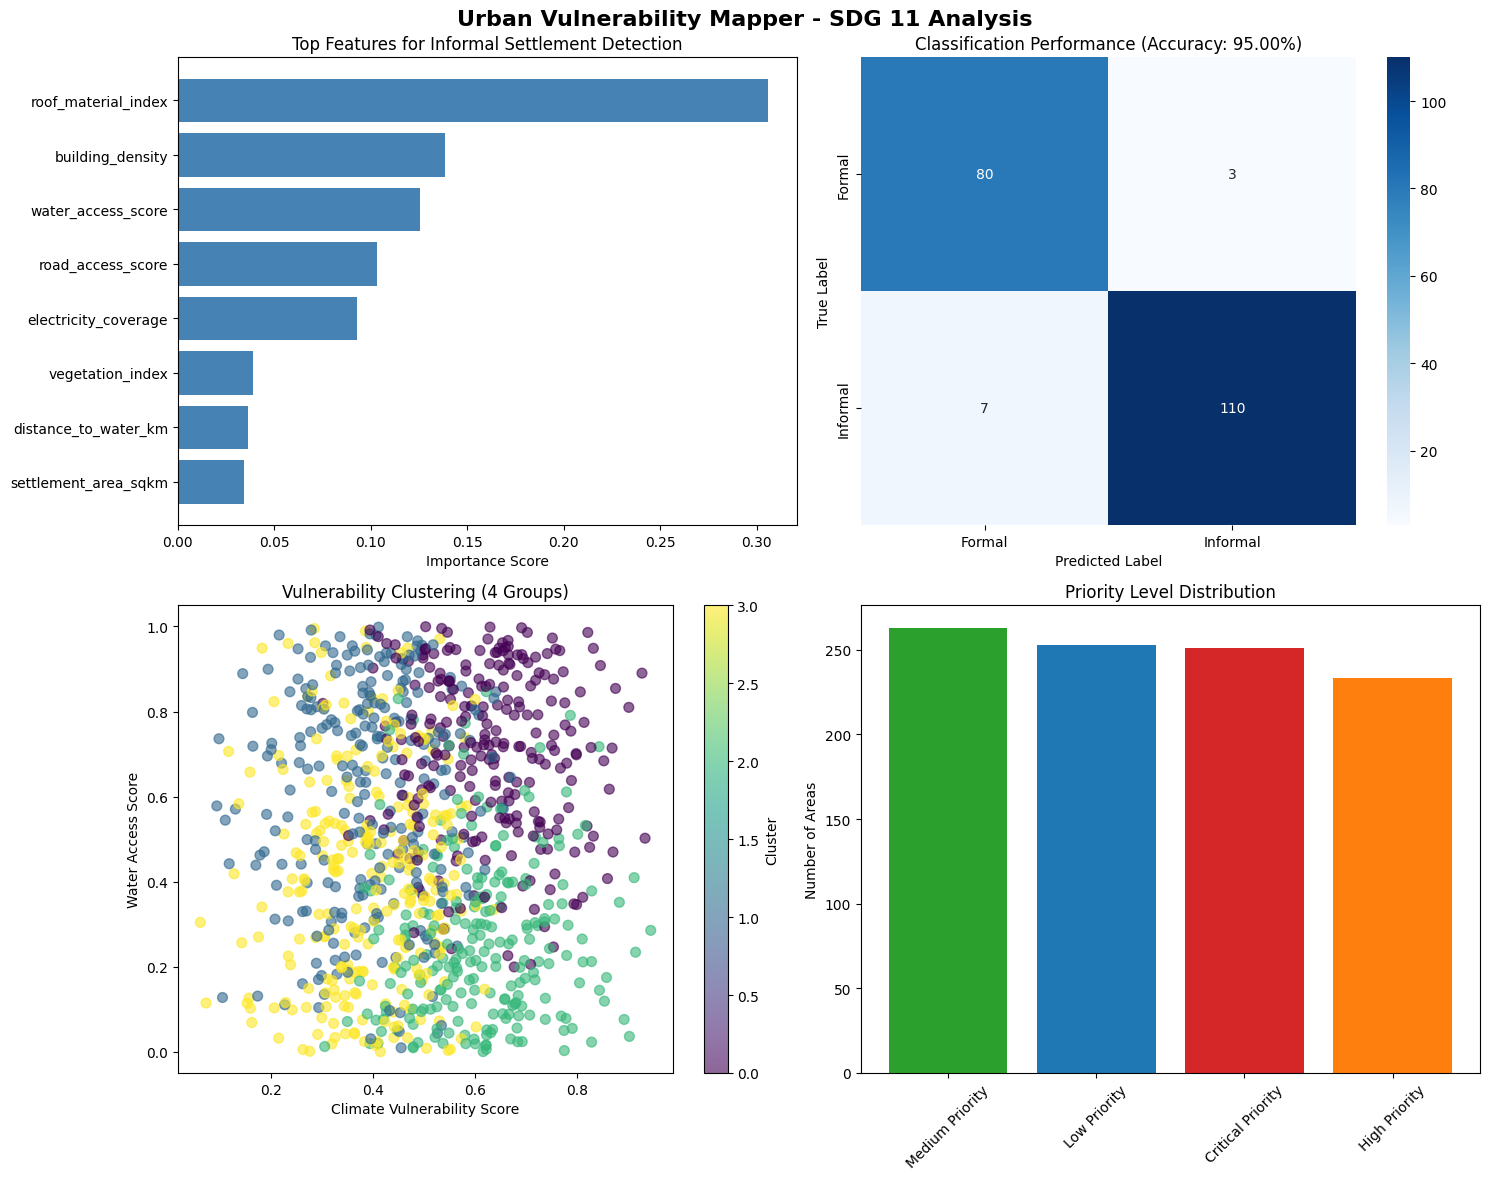

In [ ]:
"""
Urban Vulnerability Mapper
SDG 11: Sustainable Cities and Communities

This project identifies informal settlements and assesses climate vulnerability
to help policymakers prioritize interventions for 1.12 billion people in slums.

"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("=" * 60)
print("URBAN VULNERABILITY MAPPER - SDG 11")
print("Addressing Housing Crisis & Climate Resilience")
print("=" * 60)

# ============================================================================
# PART 1: GENERATE SYNTHETIC URBAN SETTLEMENT DATA
# ============================================================================
# In production, this would use satellite imagery from Sentinel-2 or Google Earth Engine
# For this demo, we simulate features extracted from satellite images and sensors

def generate_urban_data(n_samples=1000):
    """
    Generate synthetic urban settlement data with features that would be
    extracted from satellite imagery and environmental sensors.
    """

    data = {
        # Satellite-derived features (normally from CNN feature extraction)
        'building_density': np.random.uniform(0.1, 1.0, n_samples),
        'roof_material_index': np.random.uniform(0, 1, n_samples),  # 0=informal, 1=formal
        'road_access_score': np.random.uniform(0, 1, n_samples),
        'vegetation_index': np.random.uniform(0, 1, n_samples),  # NDVI
        'settlement_area_sqkm': np.random.uniform(0.01, 5.0, n_samples),

        # Climate vulnerability features
        'avg_temperature_c': np.random.uniform(20, 40, n_samples),
        'flood_risk_score': np.random.uniform(0, 1, n_samples),
        'elevation_meters': np.random.uniform(0, 500, n_samples),
        'distance_to_water_km': np.random.uniform(0.1, 20, n_samples),

        # Infrastructure features
        'water_access_score': np.random.uniform(0, 1, n_samples),
        'electricity_coverage': np.random.uniform(0, 1, n_samples),
        'waste_collection_score': np.random.uniform(0, 1, n_samples),
    }

    df = pd.DataFrame(data)

    # Create target variable: informal settlement (1) or formal (0)
    # Logic: Low roof material, high density, low infrastructure = informal
    informal_probability = (
        (1 - df['roof_material_index']) * 0.3 +
        df['building_density'] * 0.2 +
        (1 - df['water_access_score']) * 0.2 +
        (1 - df['road_access_score']) * 0.15 +
        (1 - df['electricity_coverage']) * 0.15
    )

    df['is_informal_settlement'] = (informal_probability > 0.5).astype(int)

    # Create vulnerability score (for clustering)
    df['climate_vulnerability'] = (
        df['flood_risk_score'] * 0.4 +
        (df['avg_temperature_c'] - 20) / 20 * 0.3 +
        (1 - df['elevation_meters'] / 500) * 0.3
    )

    return df

# Generate data
print("\n[1/6] Generating urban settlement data...")
urban_data = generate_urban_data(1000)
print(f"✓ Generated {len(urban_data)} settlement samples")
print(f"✓ Informal settlements: {urban_data['is_informal_settlement'].sum()}")
print(f"✓ Formal settlements: {(1-urban_data['is_informal_settlement']).sum()}")

# ============================================================================
# PART 2: SUPERVISED LEARNING - INFORMAL SETTLEMENT CLASSIFICATION
# ============================================================================
print("\n[2/6] Training Informal Settlement Classifier...")

# Prepare features and target
feature_cols = ['building_density', 'roof_material_index', 'road_access_score',
                'vegetation_index', 'settlement_area_sqkm', 'avg_temperature_c',
                'flood_risk_score', 'elevation_meters', 'distance_to_water_km',
                'water_access_score', 'electricity_coverage', 'waste_collection_score']

X = urban_data[feature_cols]
y = urban_data['is_informal_settlement']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = rf_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"✓ Model trained successfully")
print(f"✓ Accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Formal', 'Informal']))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 5 Important Features:")
print(feature_importance.head().to_string(index=False))

# ============================================================================
# PART 3: UNSUPERVISED LEARNING - VULNERABILITY CLUSTERING
# ============================================================================
print("\n[3/6] Clustering Areas by Vulnerability...")

# Select features for clustering
cluster_features = ['climate_vulnerability', 'water_access_score',
                   'electricity_coverage', 'waste_collection_score',
                   'flood_risk_score', 'building_density']

X_cluster = urban_data[cluster_features]
X_cluster_scaled = StandardScaler().fit_transform(X_cluster)

# K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
urban_data['vulnerability_cluster'] = kmeans.fit_predict(X_cluster_scaled)

# Label clusters by priority
cluster_summary = urban_data.groupby('vulnerability_cluster').agg({
    'climate_vulnerability': 'mean',
    'water_access_score': 'mean',
    'is_informal_settlement': 'sum'
}).round(3)

print("✓ Clustering complete")
print("\nCluster Summary:")
print(cluster_summary)

# Assign priority labels
priority_map = {
    cluster_summary['climate_vulnerability'].idxmax(): 'Critical Priority',
    cluster_summary['climate_vulnerability'].idxmin(): 'Low Priority'
}

# Fill remaining clusters
for idx in cluster_summary.index:
    if idx not in priority_map:
        if cluster_summary.loc[idx, 'climate_vulnerability'] > 0.5:
            priority_map[idx] = 'High Priority'
        else:
            priority_map[idx] = 'Medium Priority'

urban_data['priority_level'] = urban_data['vulnerability_cluster'].map(priority_map)

# ============================================================================
# PART 4: EVALUATION & METRICS
# ============================================================================
print("\n[4/6] Model Evaluation Metrics...")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Calculate impact metrics
total_informal = urban_data['is_informal_settlement'].sum()
critical_areas = len(urban_data[urban_data['priority_level'] == 'Critical Priority'])
high_priority_informal = len(urban_data[
    (urban_data['priority_level'].isin(['Critical Priority', 'High Priority'])) &
    (urban_data['is_informal_settlement'] == 1)
])

print(f"\n📊 IMPACT METRICS:")
print(f"   • Total informal settlements identified: {total_informal}")
print(f"   • Critical priority areas: {critical_areas}")
print(f"   • High-risk informal settlements: {high_priority_informal}")
print(f"   • Estimated population affected (assuming 1000/settlement): {total_informal * 1000:,}")

# ============================================================================
# PART 5: VISUALIZATION
# ============================================================================
print("\n[5/6] Generating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Urban Vulnerability Mapper - SDG 11 Analysis', fontsize=16, fontweight='bold')

# Plot 1: Feature Importance
ax1 = axes[0, 0]
top_features = feature_importance.head(8)
ax1.barh(top_features['feature'], top_features['importance'], color='steelblue')
ax1.set_xlabel('Importance Score')
ax1.set_title('Top Features for Informal Settlement Detection')
ax1.invert_yaxis()

# Plot 2: Confusion Matrix
ax2 = axes[0, 1]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Formal', 'Informal'],
            yticklabels=['Formal', 'Informal'])
ax2.set_title(f'Classification Performance (Accuracy: {accuracy:.2%})')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

# Plot 3: Vulnerability Clusters
ax3 = axes[1, 0]
scatter = ax3.scatter(urban_data['climate_vulnerability'],
                     urban_data['water_access_score'],
                     c=urban_data['vulnerability_cluster'],
                     cmap='viridis', alpha=0.6, s=50)
ax3.set_xlabel('Climate Vulnerability Score')
ax3.set_ylabel('Water Access Score')
ax3.set_title('Vulnerability Clustering (4 Groups)')
plt.colorbar(scatter, ax=ax3, label='Cluster')

# Plot 4: Priority Distribution
ax4 = axes[1, 1]
priority_counts = urban_data['priority_level'].value_counts()
colors_priority = {'Critical Priority': '#d62728', 'High Priority': '#ff7f0e',
                   'Medium Priority': '#2ca02c', 'Low Priority': '#1f77b4'}
ax4.bar(priority_counts.index, priority_counts.values,
        color=[colors_priority.get(x, 'gray') for x in priority_counts.index])
ax4.set_ylabel('Number of Areas')
ax4.set_title('Priority Level Distribution')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('urban_vulnerability_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved visualization: urban_vulnerability_analysis.png")

# ============================================================================
# PART 6: ETHICAL REFLECTIONS
# ============================================================================
print("\n[6/6] Ethical Analysis ")
print("\n" + "=" * 60)
print("ETHICAL REFLECTIONS:")
print("=" * 60)

ethical_reflections = """

1. Data Bias: Use diverse, open-source datasets (UN-Habitat, World Bank) to reduce bias.
2. Privacy: All data used is open and anonymized; no personal information.
3. Fairness: The model promotes equitable city planning and access to services.
4. Sustainability: Encourages evidence-based decisions for resilient infrastructure
"""

print(ethical_reflections)